In [1]:
library(hash)
library(xts)
library(lubridate)
library(forecast)
library(fpp)
library(rucm)

hash-2.2.6 provided by Decision Patterns

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Loading required package: timeDate
This is forecast 7.1 

Loading required package: fma
Loading required package: tseries
Loading required package: expsmooth
Loading required package: lmtest
Loading required package: KFAS


In [2]:
DATA_FOLDER <- "/home/samarth/workspaces/datakind-workspace/analytics/time-series/data/topNComplaints"
RESULTS_FOLDER <- "/home/samarth/workspaces/datakind-workspace/analytics/time-series/results/topNComplaints/ucm"
dataStart <- c(2012, 1)
dataEnd <- c(2015, 12)
trainStart <- c(2012, 1)
trainEnd <- c(2014, 12)
testStart <- c(2015, 1)
testEnd <- c(2015, 12)

In [3]:
loadData <- function(dataFolder) {
    files <- list.files(dataFolder)
    data <- list()
    for(file in files) {    
        df <- read.csv(paste0(dataFolder, "/", file), stringsAsFactors=F)    
        minYear <- min(df$Year)
        complaintType <- substr(file,1,(nchar(file))-4)    
        tsObject <- ts(df$Complaints, start=c(minYear, 1), frequency = 12)
        data[[complaintType]] <- window(tsObject, start=dataStart, end=dataEnd)
    }
    data
}
data <- loadData(DATA_FOLDER)
complaintTypes <- names(data)
data[[complaintTypes[1]]]

     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
2012  23  19   6 183 109  75 197 253 269 199 179 184
2013 211 143 460 299 175 174 172 380 228 215 127 108
2014 108 102 317 217 135 108 106 163 220 131  94 113
2015 131 100 197 135 118  97 140 123 167  97  35  38

,ME,RMSE,MAE,MPE,MAPE,ACF1,Theil's U
Test set,118.614010,137.245913,126.733763,38.704863,41.364622,0.274768,3.702775


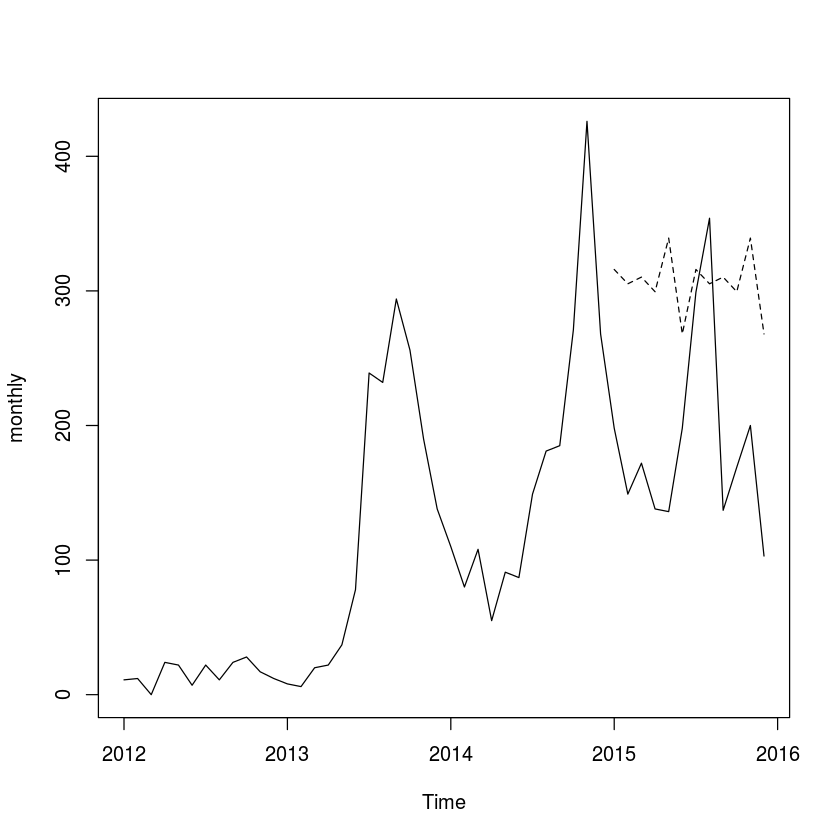

In [7]:
# try it out
monthly <- data[[complaintTypes[6]]]
trainData <- window(monthly, start=trainStart, end=trainEnd)
testData <- window(monthly, start=testStart, end=testEnd)
fit <- ucm(formula=trainData~0, data=trainData, level=T, slope = F, season = TRUE, season.length=6)
pred <- predict(fit$model, n.ahead=12)
plot(monthly)
lines(pred, lty=2, col=1)
accuracy(testData, pred)

In [9]:
# store experiment results in this data frame
results <- data.frame(Complaint.Type=c(), season.length=c(), cycle.period=c(), MAPE=c(), RMSE=c())

In [10]:
for(complaintType in complaintTypes) {
    monthly <- data[[complaintType]]
    trainData <- window(monthly, start=trainStart, end=trainEnd)
    testData <- window(monthly, start=testStart, end=testEnd)
    grid <- expand.grid(season.length=seq(1, 3), cycle.period=seq(1, 3), MAPE=NA, RMSE=NA)
    for(i in 1:nrow(grid)) {
        getAccuracy <- function(trainData, testData, g) {
            season.length <- g$season.length
            cycle.period <- g$cycle.period    
            fit <- ucm(formula=trainData~0, data=trainData, 
                       level=T, slope = T, season = T, cycle = F, 
                       season.length=season.length, cycle.period=cycle.period)
            pred <- predict(fit$model, n.ahead=12)
            return(accuracy(testData, pred))        
        }    
        g <- grid[i, ]
        acc <- tryCatch(
              getAccuracy(trainData, testData, g),
              error=function(e) e
            )
        if(inherits(acc, "error")) next        
        grid[i, ]$MAPE <- acc[1, 5]
        grid[i, ]$RMSE <- acc[1, 2]    
    }
    grid$Complaint.Type <- complaintType
    results <- rbind(results, grid)    
}

In [11]:
tail(results)

,season.length,cycle.period,MAPE,RMSE,Complaint.Type
85,1,2,NA,NA,Stagnation of water
86,2,2,NA,NA,Stagnation of water
87,3,2,93.1201477397676,1394.72837983151,Stagnation of water
88,1,3,NA,NA,Stagnation of water
89,2,3,NA,NA,Stagnation of water
90,3,3,93.1201477397676,1394.72837983151,Stagnation of water


In [12]:
write.csv(results, file=paste0(RESULTS_FOLDER,"/results.csv"), row.names=F)